In [17]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import numpy as np

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [19]:
import os
os.environ['REQUESTS_CA_BUNDLE'] = ''

In [20]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
class_names = ['Blepharitis','Conjunctivitis','Entropion','EyelidTumor','HealthyEye','Mastopathy','Nuclear Sclerosis','Pigmented Keratitis']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [21]:
from torchinfo import summary

summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 8]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [22]:
train_dir = '/Users/sandundesilva/Downloads/Datasets/train'
test_dir = '/Users/sandundesilva/Downloads/Datasets/test'

In [23]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [24]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [25]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


In [26]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=20,
                                      device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1357 | train_acc: 0.5661 | test_loss: 1.0445 | test_acc: 0.6020
Epoch: 2 | train_loss: 0.8778 | train_acc: 0.6633 | test_loss: 0.9694 | test_acc: 0.6285
Epoch: 3 | train_loss: 0.7892 | train_acc: 0.6953 | test_loss: 0.9372 | test_acc: 0.6451
Epoch: 4 | train_loss: 0.7360 | train_acc: 0.7140 | test_loss: 0.9157 | test_acc: 0.6645
Epoch: 5 | train_loss: 0.6948 | train_acc: 0.7337 | test_loss: 0.9026 | test_acc: 0.6564
Epoch: 6 | train_loss: 0.6635 | train_acc: 0.7435 | test_loss: 0.8971 | test_acc: 0.6603
Epoch: 7 | train_loss: 0.6386 | train_acc: 0.7551 | test_loss: 0.9051 | test_acc: 0.6381
Epoch: 8 | train_loss: 0.6172 | train_acc: 0.7600 | test_loss: 0.8835 | test_acc: 0.6728
Epoch: 9 | train_loss: 0.5990 | train_acc: 0.7708 | test_loss: 0.9091 | test_acc: 0.6497
Epoch: 10 | train_loss: 0.5824 | train_acc: 0.7755 | test_loss: 0.9081 | test_acc: 0.6360
Epoch: 11 | train_loss: 0.5703 | train_acc: 0.7807 | test_loss: 0.8880 | test_acc: 0.6497
Epoch: 12 | train_l

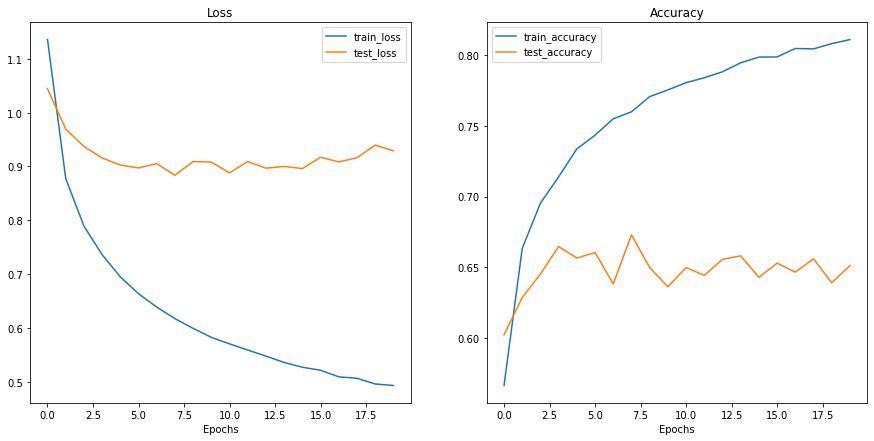

In [27]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

Class: blepharitis
Precision: 0.6811594202898551
Recall: 0.6714285714285714
F1 Score: 0.6762589928057554

Class: conjunctivitis
Precision: 0.5223880597014925
Recall: 0.49295774647887325
F1 Score: 0.5072463768115941

Class: entropion
Precision: 0.6785714285714286
Recall: 0.5428571428571428
F1 Score: 0.603174603174603

Class: eyelidTumor
Precision: 0.7066666666666667
Recall: 0.7464788732394366
F1 Score: 0.7260273972602739

Class: healthy
Precision: 0.8625
Recall: 0.9857142857142858
F1 Score: 0.9200000000000002

Class: mastopathy
Precision: 0.7236842105263158
Recall: 0.7857142857142857
F1 Score: 0.7534246575342466

Class: nuclearSclerosis
Precision: 0.5405405405405406
Recall: 0.5714285714285714
F1 Score: 0.5555555555555556

Class: pigmented  keratitis
Precision: 0.47692307692307695
Recall: 0.44285714285714284
F1 Score: 0.45925925925925926



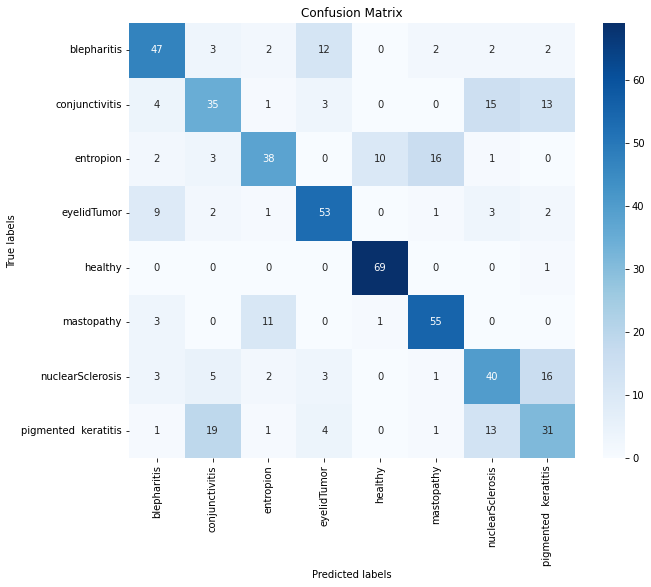

In [28]:

def calculate_metrics(model, test_dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    cm = confusion_matrix(y_true, y_pred)
    return precision, recall, f1, cm

precision, recall, f1, confusion_matrix = calculate_metrics(pretrained_vit, test_dataloader_pretrained, device)

for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print()

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


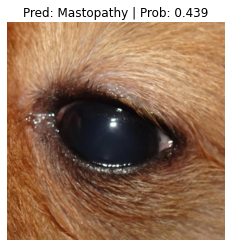

In [34]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = "/Users/chamidiperera/Downloads/Datasets/valid/mastopathy/D0_03639a9e-60a5-11ec-8402-0a7404972c70_jpg.rf.5b9981f255b2c5097a9c1434791f9976.jpg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

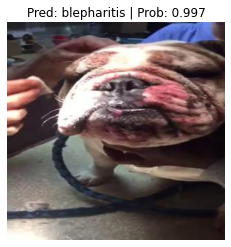

In [30]:
from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = "/Users/chamidiperera/Downloads/Datasets/Skin Datasets/validate/skin lesions/skin_lesions_00000120_jpg.rf.3670734b093e392b239870b5ab86c5fd.jpg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [31]:
model_save_path = "/Users/chamidiperera/Documents/FYP Codes/savedModels/eye/pretrained_vit_eye_final.pth"
torch.save(pretrained_vit, model_save_path)

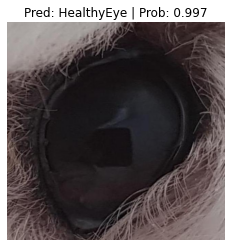

In [32]:
import requests
import torch
from going_modular.going_modular.predictions import pred_and_plot_image

class_names = ['Blepharitis','Conjunctivitis','Entropion','EyelidTumor','HealthyEye','Mastopathy','Nuclear Sclerosis','Pigmented Keratitis']

saved_model_path = "/Users/chamidiperera/Documents/FYP Codes/savedModels/eye/pretrained_vit_eye_final.pth"
pretrained_vit = torch.load(saved_model_path)

custom_image_path = "/Users/chamidiperera/Downloads/Datasets/valid/healthy/D19_2ab64e33-60a5-11ec-8402-0a7404972c70_jpg.rf.ce98692b7e74aba98af231e030b11580.jpg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)
